In [1]:
import pandas as pd
import numpy as np
from scipy import signal
import matplotlib.animation as animation
import matplotlib.pyplot as plt

In [2]:
# fpath = "F:\\pp1_data_processing\\2023-05-22_21-17-37 dac showing pacman.csv"
# fpath = "F:\\pp1_data_processing\\2023-05-22_22-36-06 dac showing pacman 200MHz.csv"
# fpath = "C:\\Users\\ionca\\Desktop\\pp1\\2023-05-23_17-58-21 dac 200MHz one line.csv"
fpath = "F:\\pp1_data_processing\\2023-05-24_21-46-19 dac showing camera feed interlaced 200MHz.csv"
df = pd.read_csv(fpath)

In [3]:
# get all the falling edges of !vid_conv where the dac data is latched
conv_diffs = df[' !VID_CONV'].diff()
dacdf = df.loc[conv_diffs == -1].copy()
dacdf.reset_index(inplace=True, drop=True)
dacdf.drop(columns=' !VID_CONV', inplace=True)
dacdf

,Time[s],DAC0,DAC1,DAC2,DAC3,DAC4,DAC5,DAC6,DAC7,VID_BLK
0,6.500000e-08,0,0,1,0,1,1,0,0,0
1,1.350000e-07,1,0,1,0,1,1,0,0,0
2,2.050000e-07,1,0,1,0,1,1,0,0,0
3,2.750000e-07,1,1,0,0,1,1,0,0,0
4,3.450000e-07,0,0,1,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...
17559344,1.226380e+00,0,0,0,1,1,1,0,0,0
17559345,1.226380e+00,0,0,0,1,1,1,0,0,0
17559346,1.226380e+00,0,0,0,1,1,1,0,0,0
17559347,1.226381e+00,1,0,1,0,1,1,0,0,0


In [4]:
vidblk_arr = dacdf[' VID_BLK'].to_numpy()
_,pk_prop = signal.find_peaks(vidblk_arr, plateau_size=[1])
pk_prop

{'plateau_sizes': array([67, 67, 67, ..., 67, 66, 67], dtype=int64),
 'left_edges': array([     151,     1061,     1971, ..., 17556781, 17557691, 17558601],
       dtype=int64),
 'right_edges': array([     217,     1127,     2037, ..., 17556847, 17557756, 17558667],
       dtype=int64)}

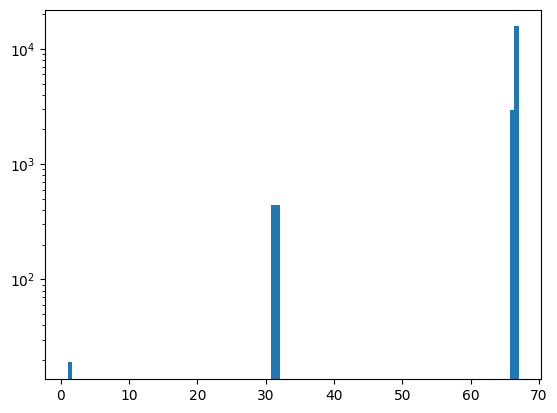

In [5]:
plt.hist(pk_prop['plateau_sizes'][pk_prop['plateau_sizes']<100], bins=100)
plt.yscale('log')
plt.show()

In [6]:
# remove glitches in the vidblk signal
for start,end in zip(pk_prop['left_edges'][pk_prop['plateau_sizes'] < 20], pk_prop['right_edges'][pk_prop['plateau_sizes'] < 20]):
    dacdf.loc[start:end, ' VID_BLK'] = 0


In [8]:
# convert binary columns to numpy
bits_arr = dacdf[[' DAC0', ' DAC1', ' DAC2', ' DAC3', ' DAC4', ' DAC5', ' DAC6', ' DAC7']].to_numpy()
# convert to decimal
decimal_arr = np.sum(bits_arr * (2**np.arange(0,8)), axis=1)
# store in new column
dacdf['VALUE'] = decimal_arr

# combine values with VID_BLK to create the video signal
dacdf['SIGNAL'] = dacdf['VALUE']
dacdf.loc[dacdf[' VID_BLK'] == 1, 'SIGNAL'] = 0
dacdf.head()

,Time[s],DAC0,DAC1,DAC2,DAC3,DAC4,DAC5,DAC6,DAC7,VID_BLK,VALUE,SIGNAL
0,6.500000e-08,0,0,1,0,1,1,0,0,0,52,52
1,1.350000e-07,1,0,1,0,1,1,0,0,0,53,53
2,2.050000e-07,1,0,1,0,1,1,0,0,0,53,53
3,2.750000e-07,1,1,0,0,1,1,0,0,0,51,51
4,3.450000e-07,0,0,1,0,1,1,0,0,0,52,52


C:\Users\ionca\AppData\Local\Temp\ipykernel_29688\1620536466.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  dacdf.iloc[:1300].plot(y=['SIGNAL', ' VID_BLK'], subplots=True, ax=ax, use_index=True)


array([<Axes: >, <Axes: >], dtype=object)

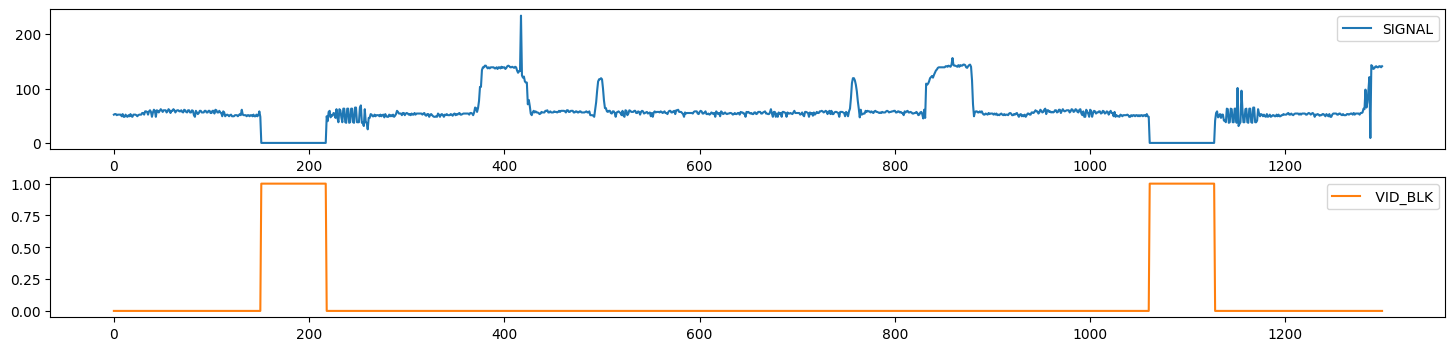

In [9]:
fig, ax = plt.subplots()
fig.set_size_inches(18, 4)
dacdf.iloc[:1300].plot(y=['SIGNAL', ' VID_BLK'], subplots=True, ax=ax, use_index=True)

timing of vid signal where falling edge of horizontal sync pulse (blanking) is t=0s  
t=-2.5650us front porch  
t=0us vidblanking  
t=4.6200us back porch  
t=5.3250us colorburst  
t=8.1250us end colorburst  
t=9.6400us begin scanline  
t=61.250us end scanline  

In [10]:
# get start and end indices of each scanline
scanline_start_indices = dacdf[dacdf[' VID_BLK'].diff() == 1].iloc[:-1].index.to_series()
scanline_end_indices = dacdf[dacdf[' VID_BLK'].diff() == 1].iloc[1:].index.to_series() - 1

# a list of dataframes that each contain a single scanline
scanlines = []
for start,end in zip(scanline_start_indices, scanline_end_indices):
    scanline = dacdf.loc[start:end, ['Time[s]', ' VID_BLK', 'VALUE', 'SIGNAL']]
    scanline['datetime'] = pd.to_datetime(scanline['Time[s]'],unit='s')
    scanlines.append(scanline)

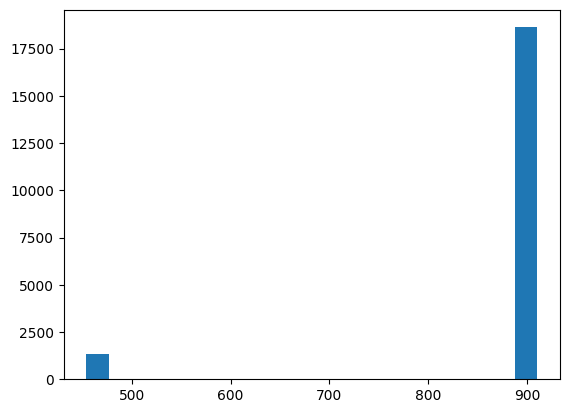

In [11]:
scanline_lengths = [x.shape[0] for x in scanlines]
plt.hist(scanline_lengths, bins=20)
plt.show()

In [12]:
scanline_lengths = np.array(scanline_lengths)

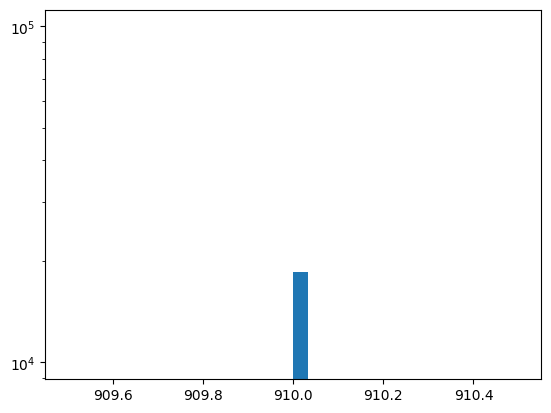

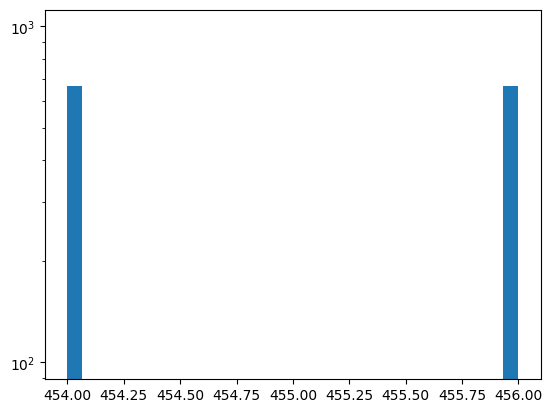

In [13]:
long_scanlines = [x for x in scanline_lengths if x > 900]
short_scanlines = [x for x in scanline_lengths if x < 900]
nbin = 30
plt.hist(long_scanlines,bins=nbin)
plt.yscale('log')
plt.show()
plt.hist(short_scanlines,bins=nbin)
plt.yscale('log')
plt.show()

In [14]:
scanline_lengths_df = pd.DataFrame(scanline_lengths)
print(scanline_lengths_df.value_counts())

910    18629
454      666
456      666
Name: count, dtype: int64


C:\Users\ionca\AppData\Local\Temp\ipykernel_29688\2666999878.py:5: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  pd.concat(scanlines[vsync-window:vsync+window]).plot(y=['SIGNAL',' VID_BLK'], subplots=True, ax=ax, use_index=True)


array([<Axes: >, <Axes: >], dtype=object)

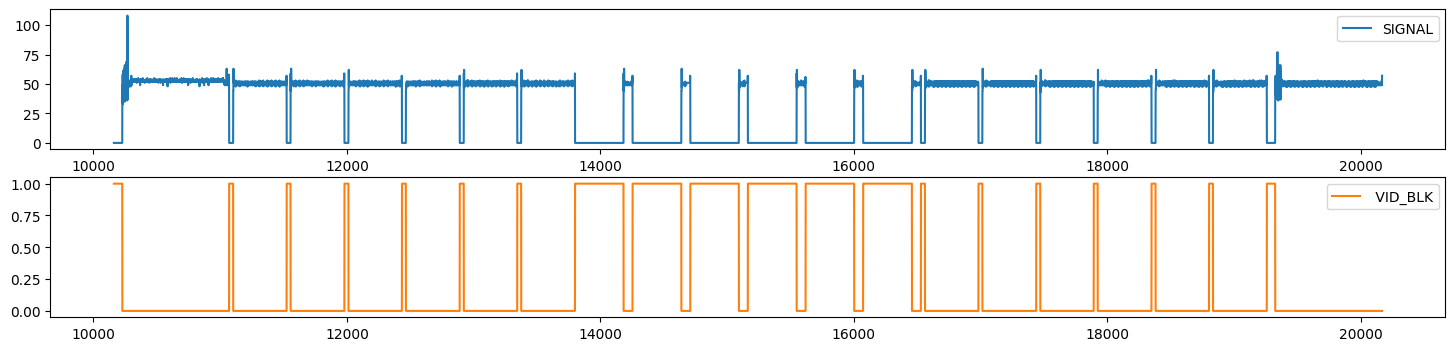

In [15]:
fig, ax = plt.subplots()
fig.set_size_inches(18, 4)
vsync = (29-12)//2 + 12 +1
window = 10
pd.concat(scanlines[vsync-window:vsync+window]).plot(y=['SIGNAL',' VID_BLK'], subplots=True, ax=ax, use_index=True)

C:\Users\ionca\AppData\Local\Temp\ipykernel_29688\2894202964.py:5: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  pd.concat(scanlines[vsync-window:vsync+window]).plot(y=['SIGNAL',' VID_BLK'], subplots=True, ax=ax, use_index=True)


array([<Axes: >, <Axes: >], dtype=object)

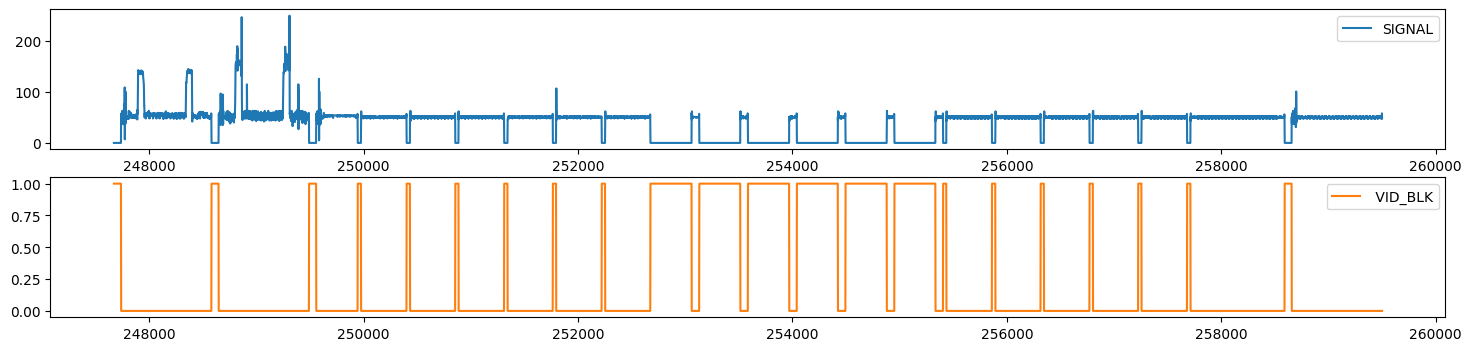

In [16]:
fig, ax = plt.subplots()
fig.set_size_inches(18, 4)
vsync = (300-283)//2 + 283 +1
window = 11
pd.concat(scanlines[vsync-window:vsync+window]).plot(y=['SIGNAL',' VID_BLK'], subplots=True, ax=ax, use_index=True)

In [17]:
print('Even field line widths')
for line in scanlines[282:289]:
    print(len(line[line[' VID_BLK'] == 0]))
print('Odd field line widths')
for line in scanlines[10:17]:
    print(len(line[line[' VID_BLK'] == 0]))


Even field line widths
843
387
425
422
425
422
425
Odd field line widths
843
843
422
425
422
425
422


In [58]:
scanlines[29]['VALUE'][220:]

19025    51
19026    52
19027    52
19028    49
19029    52
         ..
19256    53
19257    49
19258    51
19259    57
19260    49
Name: VALUE, Length: 236, dtype: int64

In [18]:
def determine_signal_states(scanlines:list, line_length_threshold=900):
    updated_scanlines = []
    _scanlines = [line.copy() for line in scanlines]
    # possible states: vsync, vsync_even, vsync_odd, even_field, odd_field, incomplete
    found_first_vsync = False
    linenumber = 0
    last_line = None
    for i in range(len(_scanlines)):
        line = _scanlines[i]
        if not found_first_vsync:
            if len(line) > line_length_threshold:
                line['STATE'] = 'incomplete'
                line['linenumber'] = -1
            else:
                found_first_vsync = True
                line['STATE'] = 'vsync'
                linenumber = 0
                line['linenumber'] = linenumber
        else:
            if len(line) > line_length_threshold: # we are not in vsync
                if 'vsync' in last_line['STATE'].iloc[0]: # we just exited vsync
                    line['STATE'] = last_line['STATE'].iloc[0].split('_')[0] + '_field'
                else: # we exited vsync a while ago
                    line['STATE'] = last_line['STATE'].iloc[0]
            else: # we are in vsync
                if 'vsync' in last_line['STATE'].iloc[0]: # we are in vsync
                    if 'vsync' == last_line['STATE'].iloc[0]: # we entered vsync on last line
                        if len(line[line[' VID_BLK'] == 0]) > len(last_line[last_line[' VID_BLK'] == 0]) \
                            and abs(len(line[line[' VID_BLK'] == 0]) - len(last_line[last_line[' VID_BLK'] == 0])) > 10: # we are in even field vsync
                                
                            line['STATE'] = 'even_vsync'
                            updated_scanlines[-1]['STATE'] = 'even_vsync'
                            updated_scanlines[-1]['linenumber'] = 0
                            linenumber = 1
                        else: # we are in odd field vsync
                            line['STATE'] = 'odd_vsync'
                            updated_scanlines[-1]['STATE'] = 'odd_vsync'
                    else: # we entered vsync a while ago
                        line['STATE'] = last_line['STATE'].iloc[0]
                else: # we just entered vsync
                    line['STATE'] = 'vsync'
            
            line['linenumber'] = linenumber
                        
        last_line = line
        updated_scanlines.append(line)
        linenumber += 1
    
    return updated_scanlines

newscanlines = determine_signal_states(scanlines)

In [19]:
print("Even Field")
print(pd.concat(newscanlines[282:289])[['STATE', 'linenumber']])
print("Odd Field")
print(pd.concat(newscanlines[10:17])[['STATE', 'linenumber']])

Even Field
             STATE  linenumber
248581   odd_field         270
248582   odd_field         270
248583   odd_field         270
248584   odd_field         270
248585   odd_field         270
...            ...         ...
252216  even_vsync           5
252217  even_vsync           5
252218  even_vsync           5
252219  even_vsync           5
252220  even_vsync           5

[3640 rows x 2 columns]
Odd Field
            STATE  linenumber
9251   incomplete          -1
9252   incomplete          -1
9253   incomplete          -1
9254   incomplete          -1
9255   incomplete          -1
...           ...         ...
13340   odd_vsync           4
13341   odd_vsync           4
13342   odd_vsync           4
13343   odd_vsync           4
13344   odd_vsync           4

[4094 rows x 2 columns]


In [20]:
fieldsdf = pd.concat(newscanlines)
fieldsdf = fieldsdf[fieldsdf['STATE'] != 'incomplete'] # drop incompletes

In [22]:
# encode states into a sequence [0,1,2,3] (even_vsync, even_field, odd_vsync, odd_field)
fieldsdf.loc[fieldsdf['STATE']=='even_vsync','statenum'] = 0
fieldsdf.loc[fieldsdf['STATE']=='even_field','statenum'] = 1
fieldsdf.loc[fieldsdf['STATE']=='odd_vsync','statenum'] = 2
fieldsdf.loc[fieldsdf['STATE']=='odd_field','statenum'] = 3
# get index of start of first even sync
start_first_even_sync = fieldsdf['statenum'].eq(0).idxmax()
# drop all rows before it
fieldsdf = fieldsdf.loc[start_first_even_sync:]
# get index of end of last odd field
end_last_odd_field = fieldsdf['statenum'].sort_index(ascending=False).eq(3).idxmax()
# drop all rows after it
fieldsdf = fieldsdf.loc[:end_last_odd_field]

In [34]:
frame_start_indices = fieldsdf[fieldsdf['statenum'].diff().eq(-3.0)].index.to_numpy()
frame_end_indices = frame_start_indices.copy() - 1
frame_start_indices = frame_start_indices.tolist()
frame_start_indices.insert(0,0)
frame_end_indices = frame_end_indices.tolist()
frame_end_indices.append(fieldsdf.index.max())

n_frames = len(frame_end_indices)

# create a numpy ndarray containing frames
frames_arr = np.ndarray((n_frames, 525, 910), np.uint8)

# extract luma info from all fields and store in frames
i = 0
for start, end in zip(frame_start_indices, frame_end_indices):
    # select the current frame's data
    only_fields = fieldsdf.loc[start:end] 
    # discard vsyncs
    only_fields = only_fields.loc[(only_fields['STATE'] == 'even_field') | (only_fields['STATE'] == 'odd_field')]
    # create new linenumbers that count hsync pulses
    only_fields['linenumber'] = (only_fields[' VID_BLK'].diff() < 0).cumsum()
    y = 0
    state = 'even'
    grouped = only_fields[['linenumber', 'datetime', 'STATE','SIGNAL']].groupby('linenumber')
    for lineno, linegroupdf in grouped:
        if state=='even' and linegroupdf['STATE'].iloc[0] == 'odd_field':
            y = 1
            state = 'odd'
            
        end = len(linegroupdf[linegroupdf['SIGNAL']>0])
        frames_arr[i, y, :end] = linegroupdf[linegroupdf['SIGNAL']>0]['SIGNAL'].to_numpy(np.uint8)
        y += 2
    i+=1


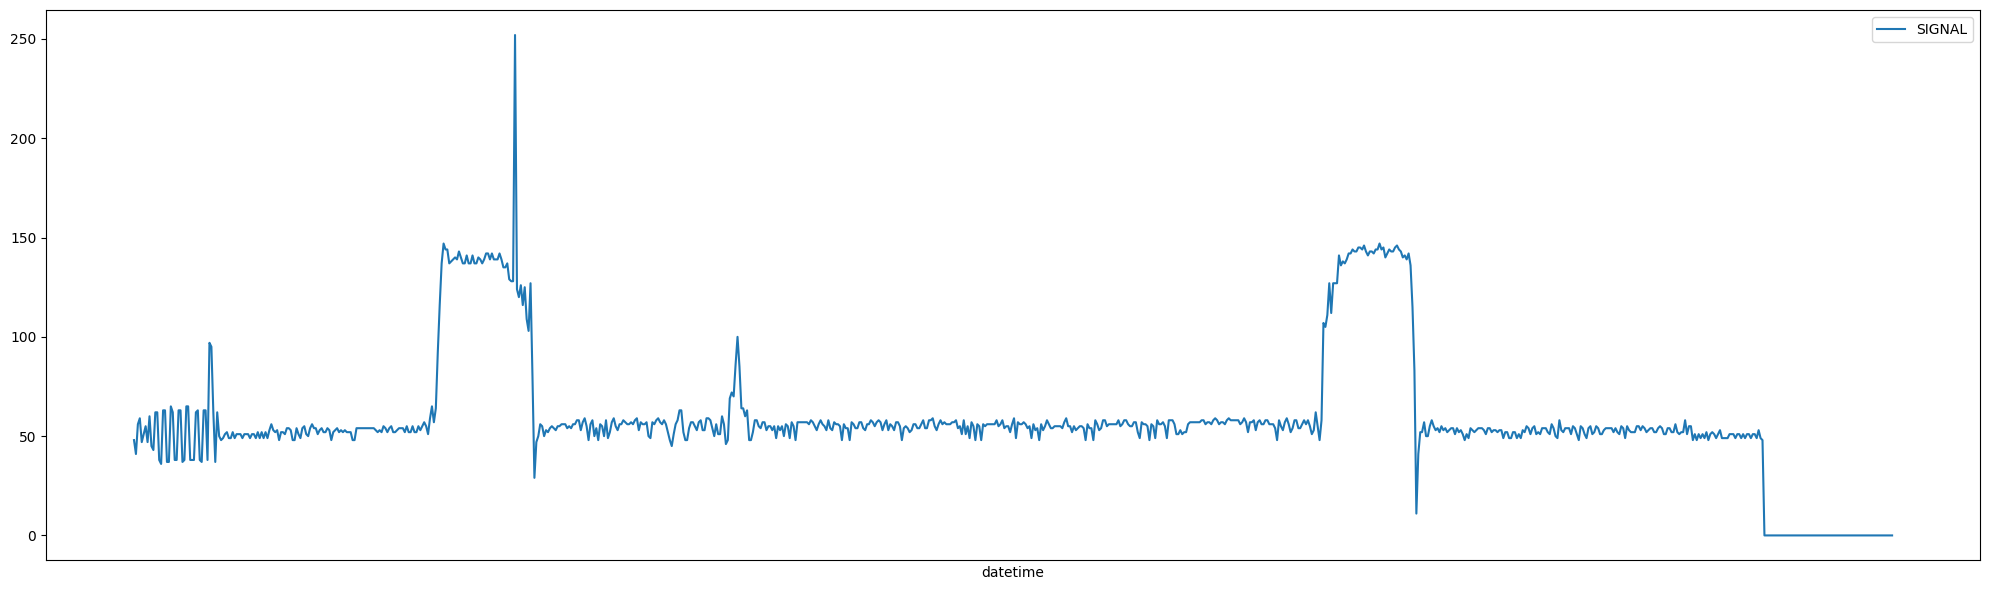

In [45]:
example_line = grouped.get_group(180)
fig,ax = plt.subplots()
fig.set_size_inches(20,6)
example_line.plot(x='datetime', y='SIGNAL', ax=ax)
plt.tight_layout()
plt.show()

In [ ]:
line_timedelta = example_line.datetime.max() - example_line.datetime.min()
line_timedelta

Timedelta('0 days 00:00:00.000063490')

In [ ]:
line_timedelta

In [260]:
frames_arr.shape

(36, 525, 910)

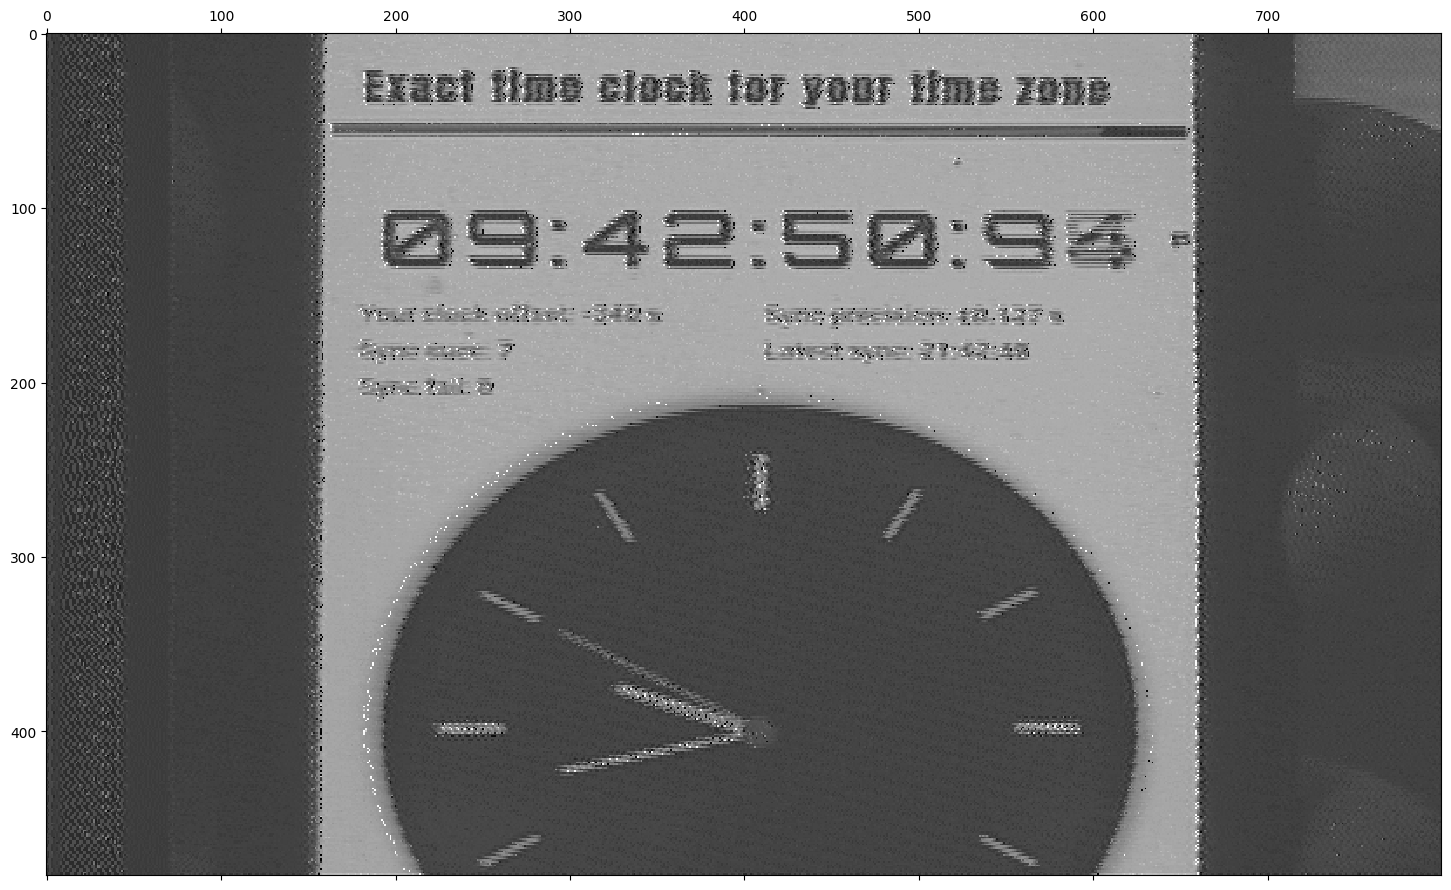

In [91]:
fig, ax = plt.subplots()
fig.set_size_inches(18,16)
ax.matshow(frames_arr[0,23:506,:800], cmap='Greys_r')
plt.show()

In [297]:
np.save('frames_arr.npy', frames_arr)

In [2]:
frames_arr_file = np.load('frames_arr.npy')
n_frames = frames_arr_file.shape[0]
frames_arr = frames_arr_file

In [4]:
plt.get_backend()

'module://matplotlib_inline.backend_inline'

In [9]:
prev_backend = 'module://matplotlib_inline.backend_inline'
plt.switch_backend('TkAgg')

fig,ax = plt.subplots()
ims = []
for i in range(n_frames):
    im = ax.matshow(frames_arr[i], cmap='Greys_r', animated=True)
    # if i == 0:
    #     ax.matshow(frames_arr[i], cmap='Greys_r') # show initial frame
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=int(2/60 * 1000,), blit=True, repeat_delay=0)
fig.show()
plt.switch_backend(prev_backend)

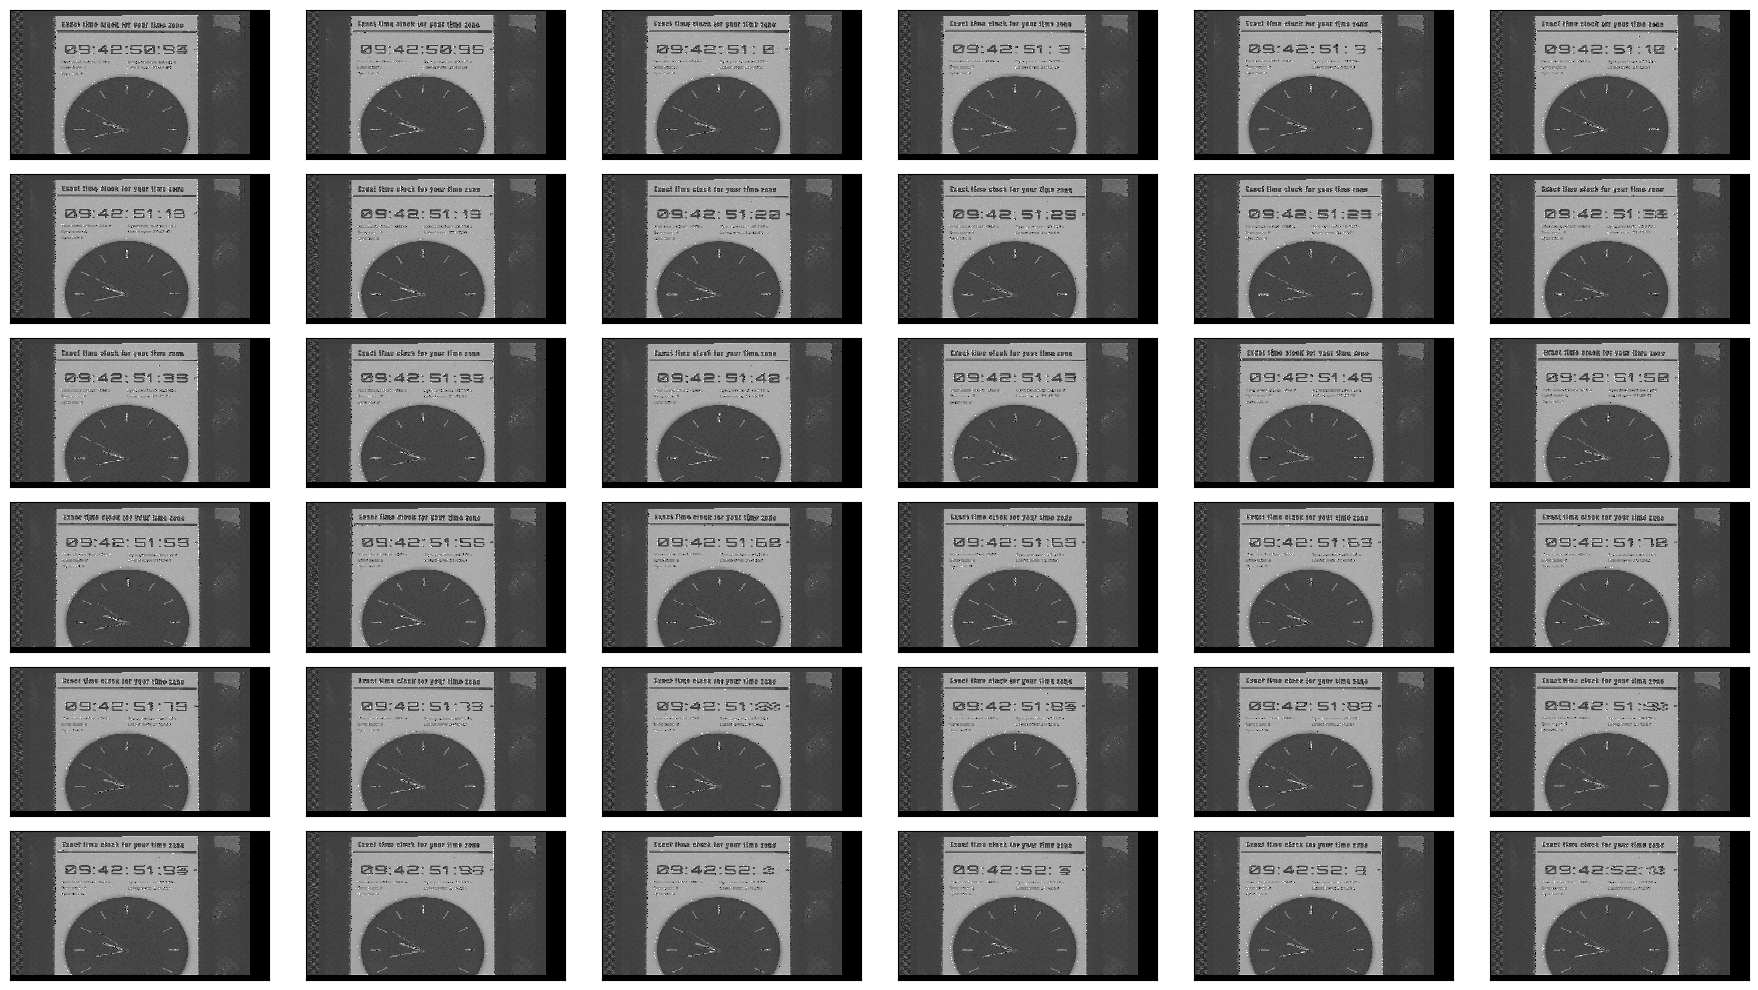

In [119]:
fig,axs = plt.subplots(nrows=6,ncols=6,figsize=(18,10))
i=0
for im in frames_arr:
    fig.axes[i].matshow(im,cmap='Greys_r', )
    fig.axes[i].set_xticks([])
    fig.axes[i].set_yticks([])
    i+=1
while i < len(fig.axes):
    fig.axes[i].matshow([[0],[0]])
    fig.axes[i].set_xticks([])
    fig.axes[i].set_yticks([])
    i+=1
plt.tight_layout()
plt.show()